In [94]:
from __future__ import annotations
import rospy
from pathlib import Path
import rosbag
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import scienceplots
from multiprocessing import Pool
from dataclasses import dataclass, field
import yaml
import logging
import re
import random
from dataclasses import dataclass

In [95]:
@dataclass
class TopicInfo:
    topic: str
    label: str
    index: int|None = None
    data: list[float] = field(default_factory=list)
    times: list[float] = field(default_factory=list)
    color: str|None = None

In [96]:
## settings
bag_file: str = "/pace-analysis/data/2025-08-16-16-03-29.bag"

leg_idx: int = 0  # 0: FL, 1: FR, 2: RL, 3: RR

topic_infos: list[TopicInfo] = [
    TopicInfo(
        topic="/contact_estimation/leg_contact_time_prob", 
        label="FL Leg Contact Control", 
        index=leg_idx
    ),
    TopicInfo(
        topic="/contact_estimation/leg_contact", 
        label="FL Leg Contact PACE", 
        index=leg_idx,
        color="blue"
    ),
]

start_time_offset: float = 1755374610.500  # epoch time to subtract from all times for plotting

graph_range: list[float] = [1755374623.500, 1755374628.500]

slip_regions: list[list[float]] = [
    [1755374623.728,1755374623.995],
    [1755374624.398,1755374624.598],
    [1755374624.847,1755374625.014],
    [1755374625.412,1755374625.612],
    [1755374626.078,1755374626.245],
    [1755374626.748,1755374626.915],
    [1755374627.948,1755374628.115],
]

In [97]:
## get data
bag = rosbag.Bag(bag_file)

start_time = rospy.Time.from_sec(graph_range[0])
end_time = rospy.Time.from_sec(graph_range[1])
topics = [cfg.topic for cfg in topic_infos]
msg_iter = bag.read_messages(topics=topics, start_time=start_time, end_time=end_time)

msg_data = {
    topic: [] for topic in topics
}

for topic, msg, time in msg_iter:
    value = getattr(msg, 'data', None)

    if topic == "/contact_estimation/leg_contact_time_prob":
        value = [v > 0.8 for v in value]

    if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
        value = list(value)
        
    msg_data[topic].append((time.to_sec(), value))


In [98]:
## move data into the TopicInfo structures
topic_to_config = {cfg.topic: cfg for cfg in topic_infos}

for topic, entries in msg_data.items():
    cfg = topic_to_config[topic]
    for t, v in entries:
        cfg.times.append(t)
        if cfg.index is not None and isinstance(v, list):
            v = v[cfg.index]
        cfg.data.append(v)

In [99]:
## adjust data times by offset
for cfg in topic_infos:
    cfg.times = [t - start_time_offset for t in cfg.times]

slip_regions = [[t[0] - start_time_offset, t[1] - start_time_offset] for t in slip_regions]

In [100]:
## for each topic info, move their z values down by a small ammount so they are easier to see
for i, cfg in enumerate(topic_infos):
    offset = 0.015 * i
    cfg.data = [v - offset for v in cfg.data]

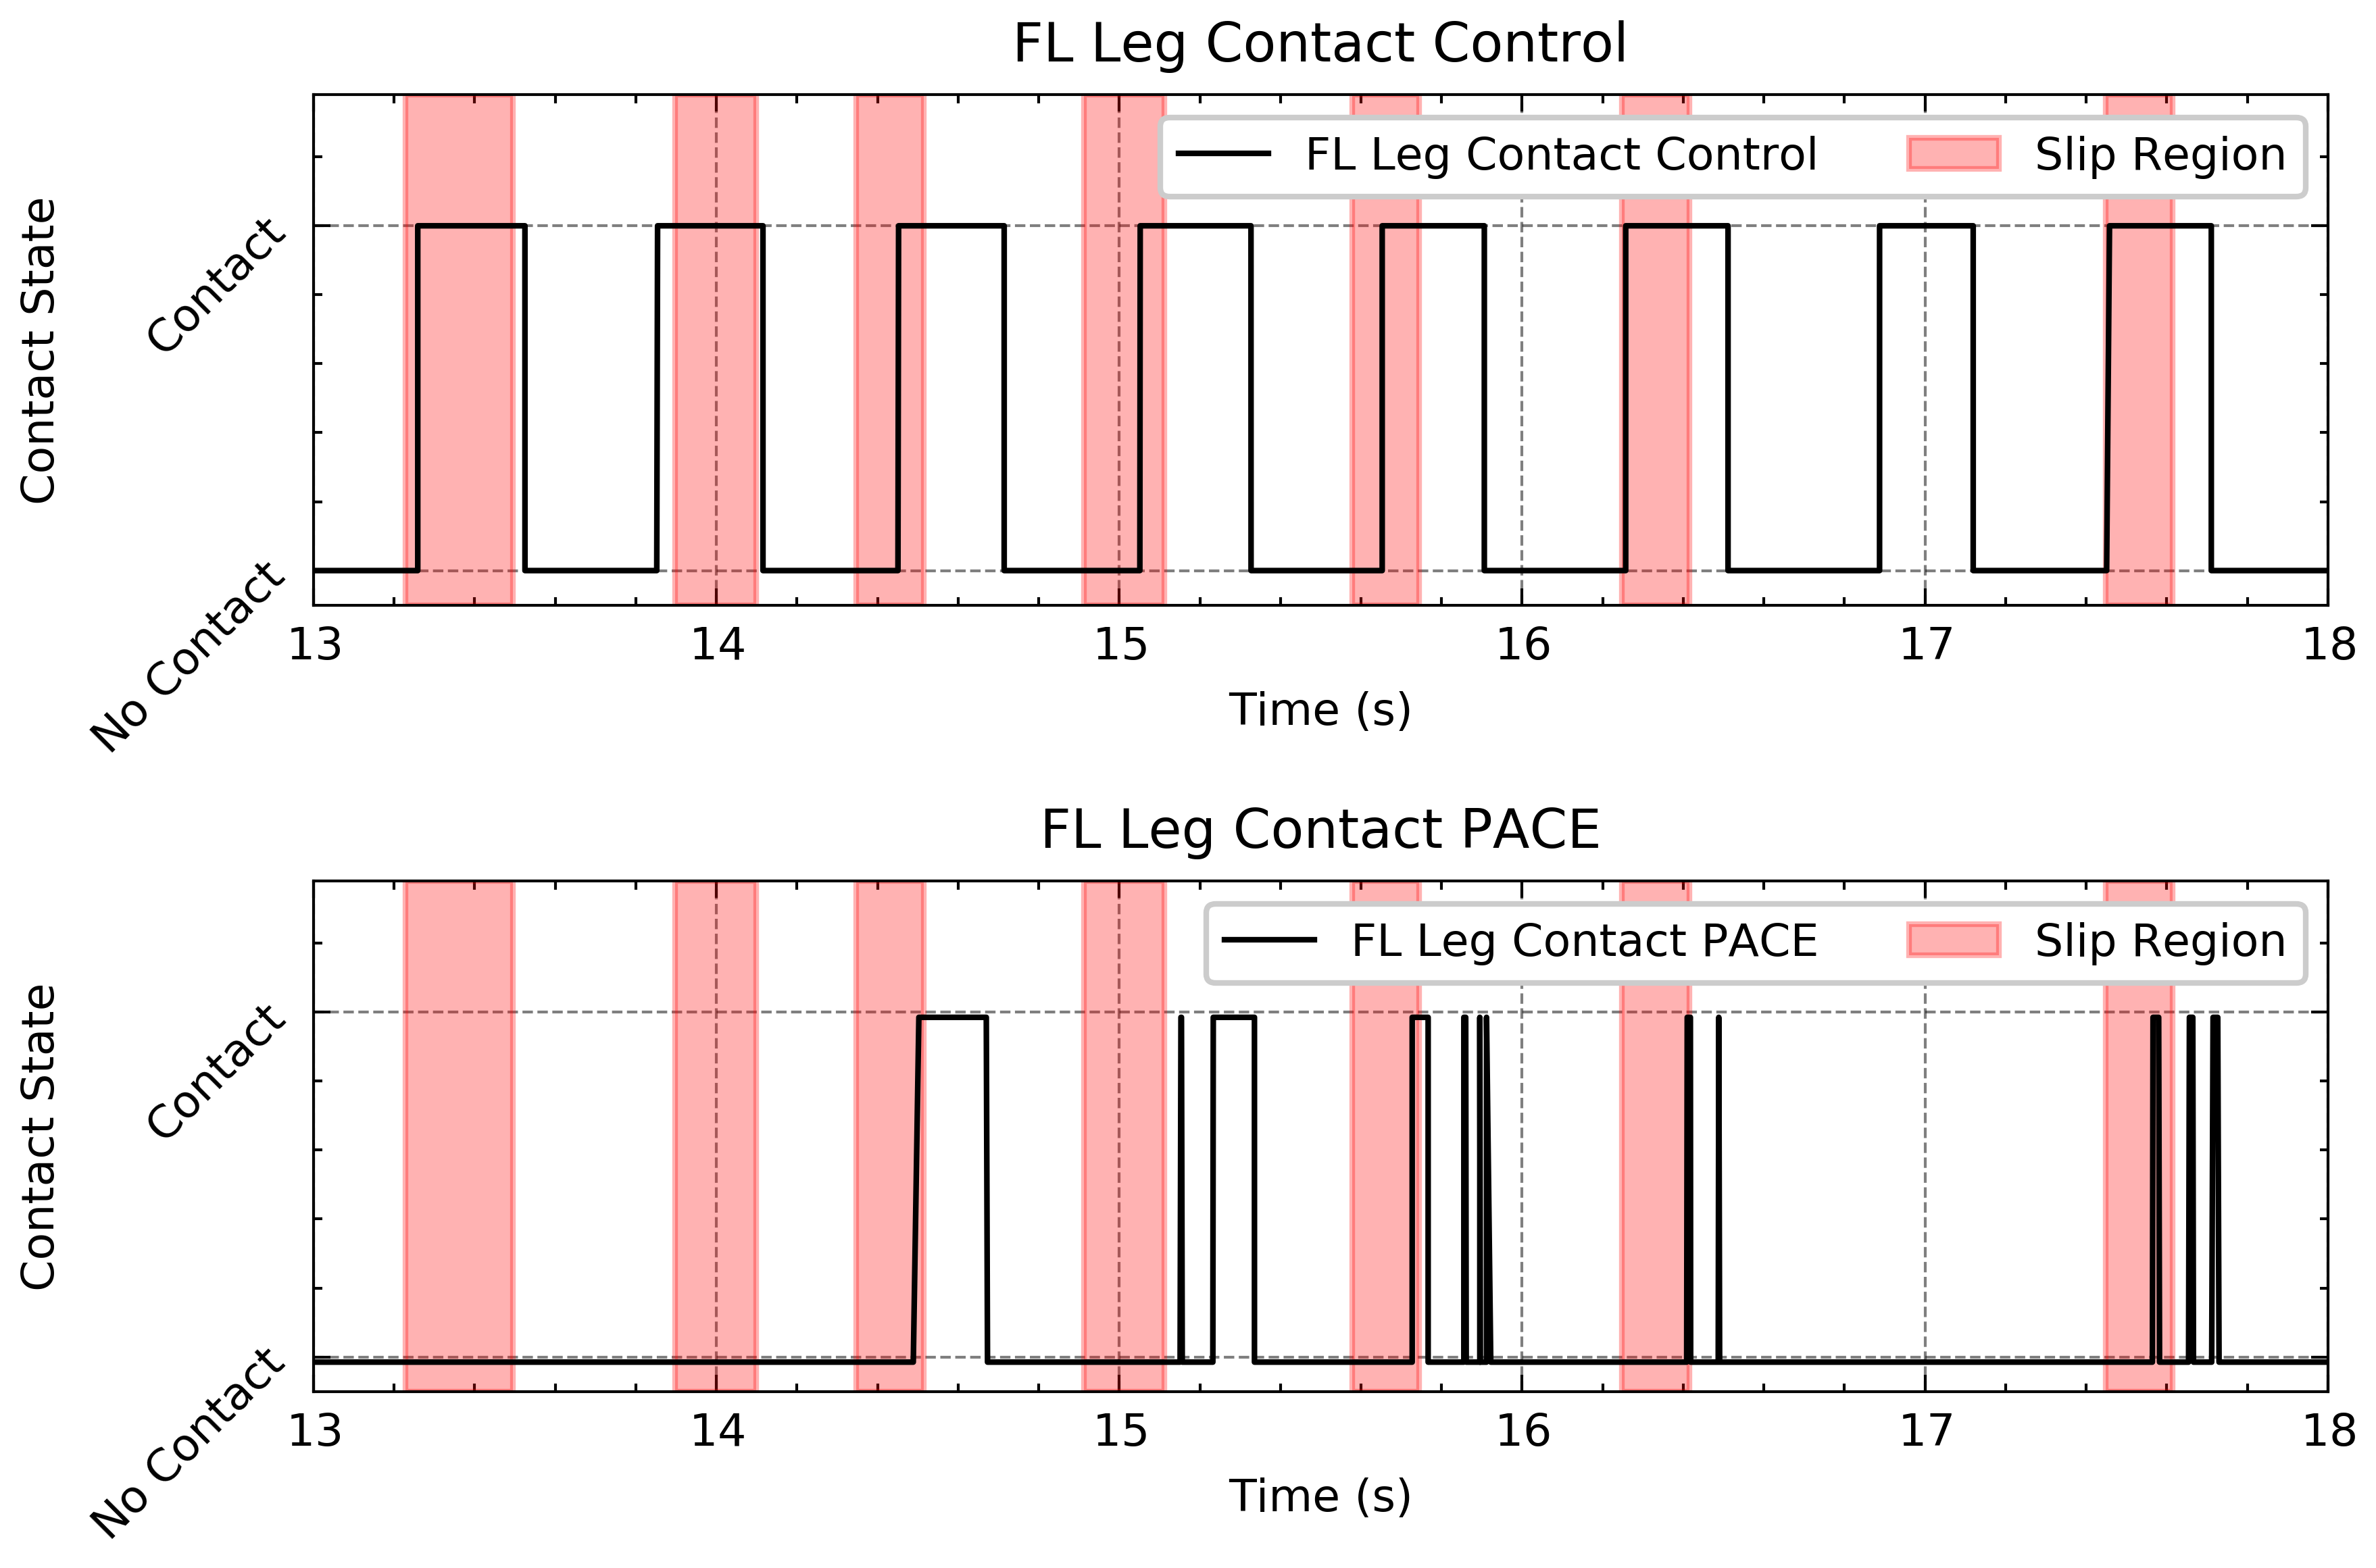

In [101]:
# plot data for each topic info
plt.style.use(['ieee', 'grid'])
num_topics = len(topic_infos)
fig, axes = plt.subplots(num_topics, 1, figsize=(6, 2*num_topics), sharex=False)
if num_topics == 1:
    axes = [axes]
for ax, cfg in zip(axes, topic_infos):
    ax.plot(cfg.times, cfg.data, label=cfg.label)
    ax.grid(True)
    ax.set_title(cfg.label)
    ax.set_xlabel("Time (s)")
    for i, region in enumerate(slip_regions):
        ax.axvspan(region[0], region[1], color='red', alpha=0.3, label='Slip Region' if i == 0 else "")
    ax.legend(loc='upper right', ncol=2)

    ax.set_ylim((-0.1, 1.38))
    ax.set_ylabel("Contact State")
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["No Contact", "Contact"], rotation=45)
    ax.set_xlim((graph_range[0] - start_time_offset, graph_range[1] - start_time_offset))

# Adjust layout
plt.tight_layout()
plt.show()

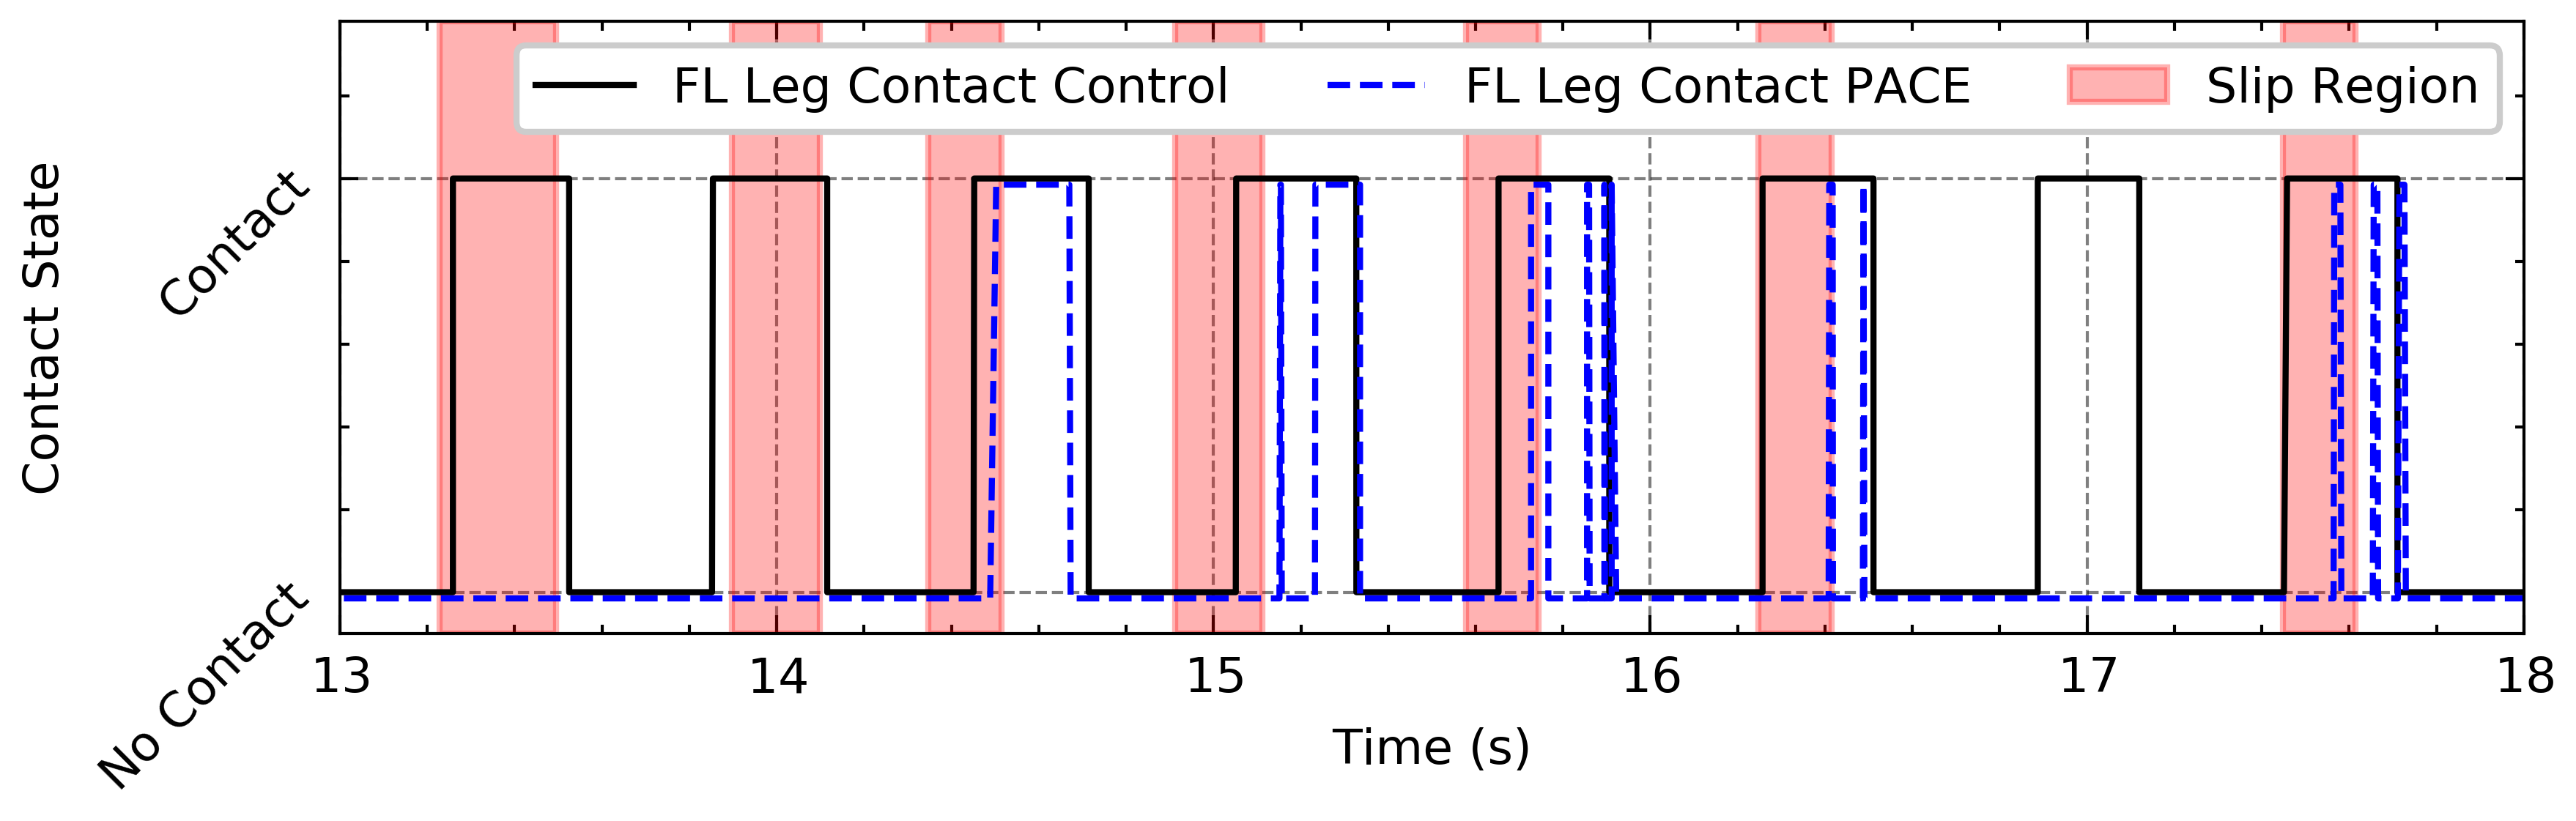

In [102]:
# plot data for all topic infos on the same axes
plt.style.use(['ieee', 'grid'])
fig, ax = plt.subplots(figsize=(6, 2))

# plot each topic on the same axis
for cfg in topic_infos:
    kwargs = {}
    if cfg.color is not None:
        kwargs['color'] = cfg.color
    ax.plot(cfg.times, cfg.data, label=cfg.label, **kwargs)

# mark slip regions
for i, region in enumerate(slip_regions):
    ax.axvspan(region[0], region[1], color='red', alpha=0.3, label='Slip Region' if i == 0 else "")

# formatting
ax.grid(True)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Contact State")
ax.set_yticks([0, 1])
ax.set_yticklabels(["No Contact", "Contact"], rotation=45)
ax.set_xlim((graph_range[0] - start_time_offset, graph_range[1] - start_time_offset))
ax.set_ylim((-0.1, 1.38))
ax.legend(loc='upper right', ncol=3)

# adjust layout
plt.tight_layout()
plt.show()


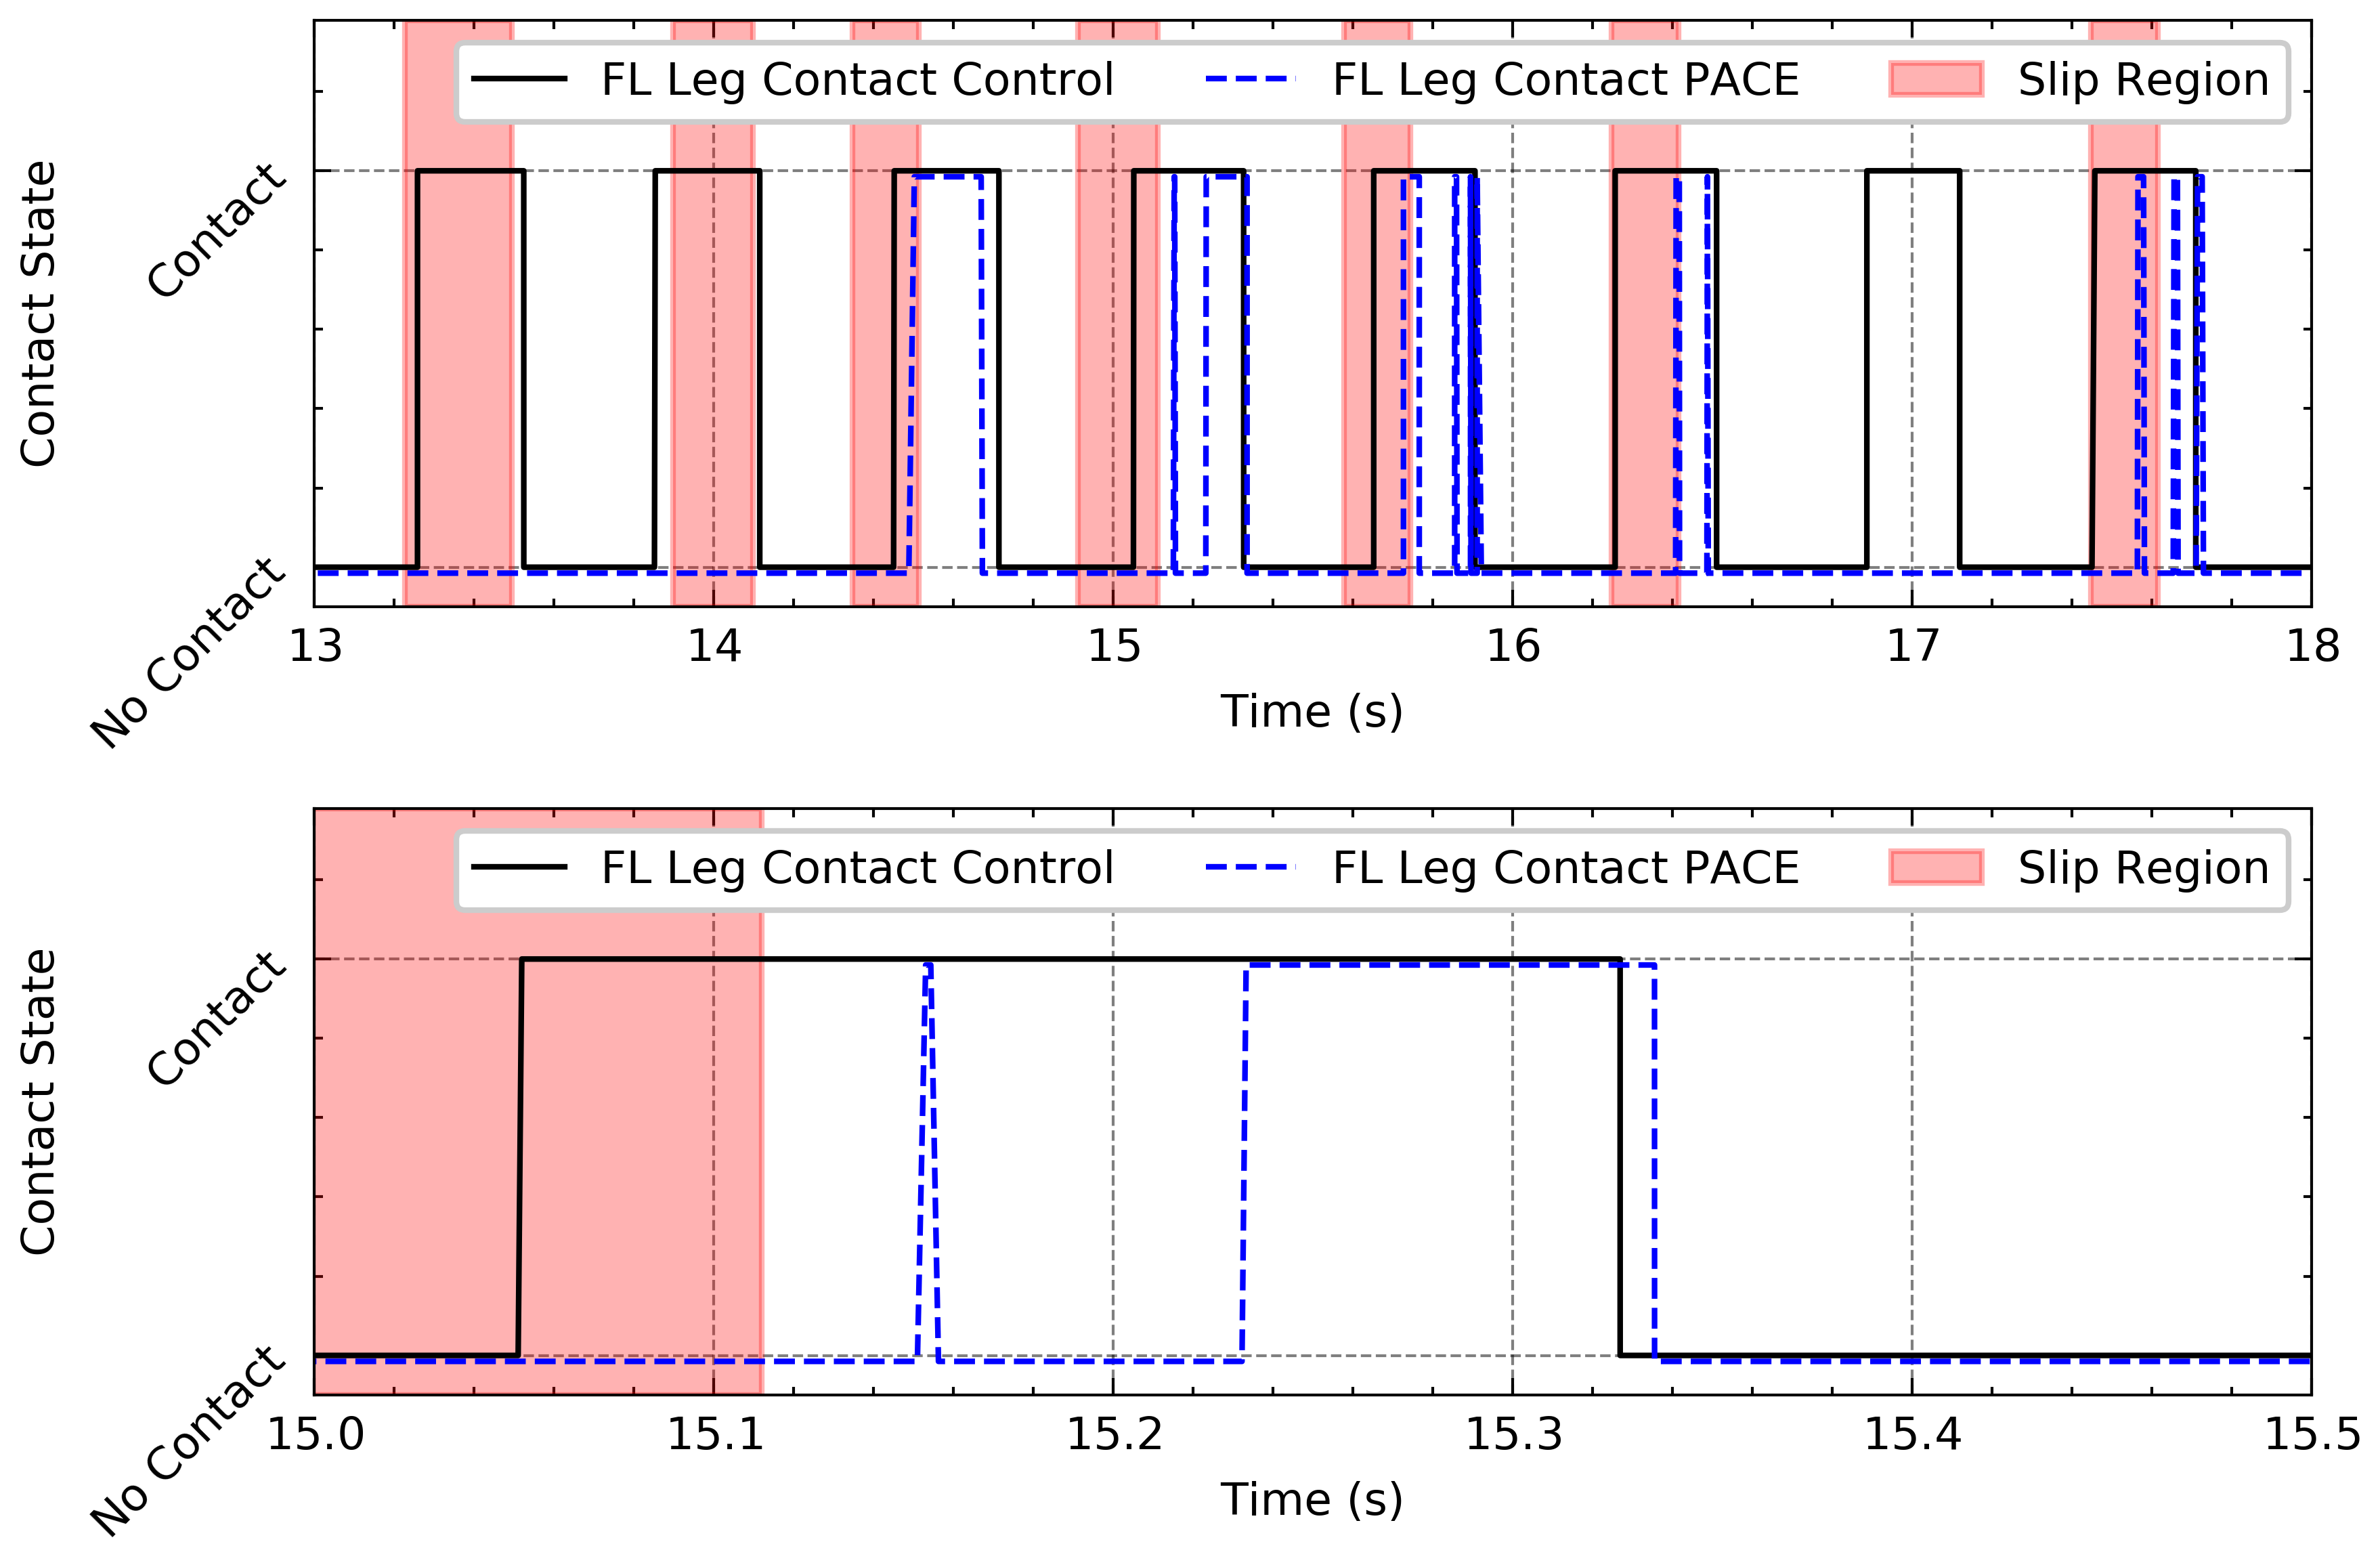

In [103]:
# plot data for all topic infos on the same axes
plt.style.use(['ieee', 'grid'])
fig, axes = plt.subplots(2, 1, figsize=(6, 4))

for ax in axes:
    # plot each topic on the same axis
    for cfg in topic_infos:
        kwargs = {}
        if cfg.color is not None:
            kwargs['color'] = cfg.color
        ax.plot(cfg.times, cfg.data, label=cfg.label, **kwargs)

    # mark slip regions
    for i, region in enumerate(slip_regions):
        ax.axvspan(region[0], region[1], color='red', alpha=0.3, label='Slip Region' if i == 0 else "")

    # formatting
    ax.grid(True)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Contact State")
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["No Contact", "Contact"], rotation=45)
    ax.set_xlim((graph_range[0] - start_time_offset, graph_range[1] - start_time_offset))
    ax.set_ylim((-0.1, 1.38))
    ax.legend(loc='upper right', ncol=3)


axes[0].set_xlim((graph_range[0] - start_time_offset, graph_range[1] - start_time_offset))
axes[1].set_xlim((15, 15.5))
# adjust layout
plt.tight_layout()
plt.show()